In [1]:
from itertools import product

import numpy as np
from graspy.simulations import er_np, sbm
from graspy.plot import heatmap
from scipy.stats import ttest_ind
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def generate_data(m = 1, n = [5, 15], p = 0.5, delta = 0, seed = None):
    np.random.seed(seed)
    p1 = [[p, p],
          [p, p]]
    p2 = [[p + delta, p],
          [p, p]]
    
    pop1 = []
    pop2 = []
    for _ in np.arange(m):
        pop1.append(sbm(n, p1))
        pop2.append(sbm(n, p2))
    
    pop1 = np.stack(pop1)
    pop2 = np.stack(pop2)
    return pop1, pop2

def compute_ttest(pop1, pop2):
    statistics, pvals = ttest_ind(pop1, pop2, axis=0)
    np.nan_to_num(statistics, copy=False)
    np.nan_to_num(pvals, copy=False)

    return statistics, pvals

def compute_pr_at_k(different_n, k, test_statistics):
    n = test_statistics.shape[0]
    labels = np.zeros((n, n))
    labels[0:different_n, 0:different_n] = 1
    
    triu_idx = np.triu_indices_from(test_statistics, k=1)
    test_statistics_ = test_statistics[triu_idx]
    labels_ = labels[triu_idx]
    
    idx = np.argsort(test_statistics_, kind='stable')
    sorted_labels = labels_[idx]
    
    precision_at_k = sorted_labels[:k].mean()
    recall_at_k = sorted_labels[:k].sum() / sorted_labels.sum()
    
    return precision_at_k, recall_at_k

In [3]:
def run_experiment(m, delta, seed, reps):
    precisions = []
    recalls = []   
    for i in np.arange(reps):
        tmp_precisions = []
        tmp_recalls = [] 
        pop1, pop2 = generate_data(m = m, n = n, p = p, delta=delta, seed = seed+i)
        test_statistics, pvals = compute_ttest(pop1, pop2)
        
        for k in range(1, 11):
            precision, recall = compute_pr_at_k(5, k, test_statistics)
            tmp_precisions.append(precision)
            tmp_recalls.append(recall)
            
        precisions.append(tmp_precisions)
        recalls.append(tmp_recalls)
            
    precisions = np.array(precisions).mean(axis=0)
    recalls = np.array(recalls).mean(axis=0)
    
    to_append = [p, delta, m, *precisions, *recalls]

    return to_append

In [4]:
block_1 = 5 # different probability
block_2 = 15
n = [block_1, block_2]
p = 0.5
deltas = np.linspace(0, 1 - p, 100)
ms = np.linspace(10, 1000, 100)

#deltas = np.linspace(0, 1 - p, 2)
#ms = np.linspace(10, 1000, 2)

reps=500

In [ ]:
args = [(m, delta, seed*reps, reps) for seed, (m, delta) in enumerate(product(ms, deltas))]

res = Parallel(n_jobs=-2, verbose=1)(
    delayed(run_experiment)(
        *arg
    ) for arg in args
)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 47 concurrent workers.
[Parallel(n_jobs=-2)]: Done 106 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-2)]: Done 356 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-2)]: Done 706 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-2)]: Done 1156 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-2)]: Done 1706 tasks      | elapsed: 59.7min
[Parallel(n_jobs=-2)]: Done 2356 tasks      | elapsed: 110.3min
[Parallel(n_jobs=-2)]: Done 3106 tasks      | elapsed: 188.7min
[Parallel(n_jobs=-2)]: Done 3956 tasks      | elapsed: 302.3min
[Parallel(n_jobs=-2)]: Done 4906 tasks      | elapsed: 461.7min


In [11]:
cols =  ['p', 'delta', 'm', 'fraction_correct', 'all_correct']
res_df = pd.DataFrame(columns = cols) 

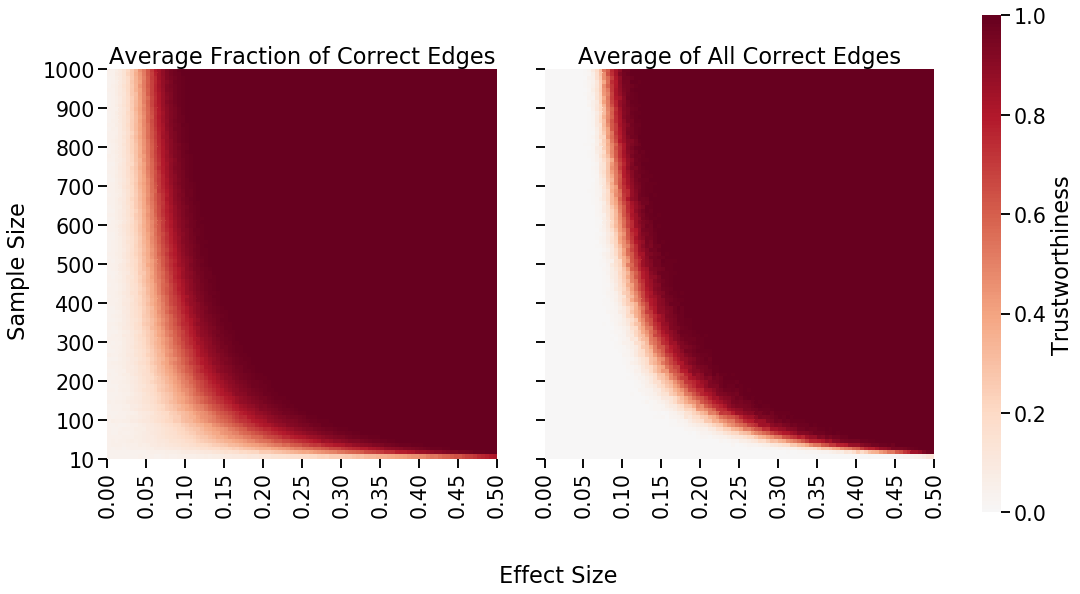

In [172]:
samples = np.arange(0, 1001, 100)
samples[0] += 10
samples = [str(i) for i in samples]

fmt = lambda x: "{:.2f}".format(x)

with sns.plotting_context('talk', font_scale=1.25):
    # fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 0.05]}, figsize=(15, 8))
    
    sns.heatmap(
        np.flipud(res_df.fraction_correct.values.reshape(100, -1)),
        ax = ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels=[fmt(i) for i in np.linspace(0, 1 - p, 101)[::10]],
        yticklabels=samples,
        cbar_ax=ax[-1]
    )
    ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1]+1, 10))
    ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0]+1, 10)[::-1])
    ax[0].set_title("Average Fraction of Correct Edges")
    
    sns.heatmap(
        np.flipud(res_df.all_correct.values.reshape(100, -1)),
        ax = ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7, label='Trustworthiness'),
        xticklabels=[fmt(i) for i in np.linspace(0, 1 - p, 101)[::10]],
        #yticklabels=samples,
        cbar_ax=ax[-1]
    )
    ax[1].set_xticks(np.arange(0, ax[1].get_xlim()[1]+1, 10))
    ax[1].set_yticks(np.arange(0, ax[1].get_ylim()[0]+1, 10)[::-1])
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].set_title("Average of All Correct Edges")


    fig.text(-0.01, 0.5, "Sample Size", va='center', rotation='vertical')
    fig.text(0.5, -0.03, "Effect Size", va='center', ha='center')
    
    fig.tight_layout()

In [174]:
fig.savefig("j1c-new-experiment.png", dpi=300, bbox_inches='tight')
fig.savefig("j1c-new-experiment.pdf", bbox_inches='tight')